# Train CNN

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import cv2
import numpy as np

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Custom Dataset for loading images and csv data with filenames in CSV
class CustomDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.csv_data = pd.read_csv(csv_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.csv_data)
    
    def __getitem__(self, idx):
        # Load image_filename, x, y, size from CSV
        row = self.csv_data.iloc[idx]
        image_filename = row['image_filename']  # Get the image filename from the CSV
        x, y, size = row[['x', 'y', 'size']].values.astype(np.float32)
        inputs = np.array([x, y, size], dtype=np.float32)
        
        # Load the image
        image_path = os.path.join(self.image_dir, image_filename)
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_path} not found.")
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (64, 64))
        
        # Normalize the image to [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Add channel dimension (1 for grayscale)
        image = image[np.newaxis, :, :]  # Convert shape from (64, 64) to (1, 64, 64)
        
        # Ensure the final shape is [1, 64, 64] (channel-first)
        image = torch.tensor(image, dtype=torch.float32)  # Now shape is [1, 64, 64]
        
        return torch.tensor(inputs), image

# Image transformations (Normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset and Dataloaders
train_image_dir = '/home/tim/Documents/04_Projekt_ConSim/lens_contamination_simulation/data/train/gt_droplet_clusters'
test_image_dir = '/home/tim/Documents/04_Projekt_ConSim/lens_contamination_simulation/data/test/gt_droplet_clusters'

train_csv_path = '/home/tim/Documents/04_Projekt_ConSim/lens_contamination_simulation/data/train/xy_size_data_train_droplet_clusters.csv'
test_csv_path = '/home/tim/Documents/04_Projekt_ConSim/lens_contamination_simulation/data/test/xy_size_data_test_droplet_clusters.csv'

train_dataset = CustomDataset(train_image_dir, train_csv_path, transform=transform)
test_dataset = CustomDataset(test_image_dir, test_csv_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition with latent noise for variability
class ShapeGeneratorModel(nn.Module):
    def __init__(self, noise_dim=100):
        super(ShapeGeneratorModel, self).__init__()
        self.noise_dim = noise_dim
        
        # Linear layers, input dimension includes noise + structured input (x, y, size)
        self.fc1 = nn.Linear(3 + noise_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        
        # Output size to match input for ConvTranspose layers
        self.fc3 = nn.Linear(512, 16 * 16 * 64)
        
        # Transposed convolution layers to upsample to 64x64
        self.conv_transpose1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, xy_size):
        # Generate random noise
        batch_size = xy_size.size(0)
        z = torch.randn(batch_size, self.noise_dim, device=xy_size.device)
        
        # Concatenate structured input (x, y, size) with noise
        x = torch.cat([xy_size, z], dim=1)
        
        # Pass through fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        
        # Reshape to fit into ConvTranspose layers
        x = x.view(-1, 64, 16, 16)  # Reshape to (batch_size, channels, height, width)
        
        # Upsample to 64x64 using ConvTranspose layers
        x = self.relu(self.conv_transpose1(x))  # 32x32
        x = self.relu(self.conv_transpose2(x))  # 64x64
        x = self.sigmoid(self.conv_transpose3(x))  # Final binary mask (64x64)
        
        return x

# Instantiate the model
model = ShapeGeneratorModel().to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
early_stopping_patience = 5
best_loss = float('inf')
patience_counter = 0

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    global best_loss, patience_counter
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, images in train_loader:
            inputs, images = inputs.to(device), images.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Ensure the shapes match
            assert outputs.shape == images.shape, f"Output shape {outputs.shape} does not match target shape {images.shape}"
            
            # Compute loss
            loss = criterion(outputs, images)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Early stopping logic
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), '/home/tim/Documents/04_Projekt_ConSim/lens_contamination_simulation/train_model/models/best_model_droplet.pth')  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break




Using device: cuda


## Train

In [2]:
# Training the model
train_model(model, train_loader, criterion, optimizer)

# Testing the model
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, images in test_loader:
            inputs, images = inputs.to(device), images.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, images)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('/home/tim/Documents/04_Projekt_ConSim/lens_contamination_simulation/train_model/models/best_model_droplet.pth'))
evaluate_model(model, test_loader)

Epoch 1/50, Loss: 0.3156
Epoch 2/50, Loss: 0.1993
Epoch 3/50, Loss: 0.1985
Epoch 4/50, Loss: 0.1983
Epoch 5/50, Loss: 0.1940
Epoch 6/50, Loss: 0.1968
Epoch 7/50, Loss: 0.1948
Epoch 8/50, Loss: 0.1956
Epoch 9/50, Loss: 0.1937
Epoch 10/50, Loss: 0.1929
Epoch 11/50, Loss: 0.1930
Epoch 12/50, Loss: 0.1875
Epoch 13/50, Loss: 0.1876
Epoch 14/50, Loss: 0.1827
Epoch 15/50, Loss: 0.1750
Epoch 16/50, Loss: 0.1641
Epoch 17/50, Loss: 0.1594
Epoch 18/50, Loss: 0.1516
Epoch 19/50, Loss: 0.1482
Epoch 20/50, Loss: 0.1442
Epoch 21/50, Loss: 0.1401
Epoch 22/50, Loss: 0.1356
Epoch 23/50, Loss: 0.1325
Epoch 24/50, Loss: 0.1286
Epoch 25/50, Loss: 0.1266
Epoch 26/50, Loss: 0.1206
Epoch 27/50, Loss: 0.1208
Epoch 28/50, Loss: 0.1134
Epoch 29/50, Loss: 0.1140
Epoch 30/50, Loss: 0.1113
Epoch 31/50, Loss: 0.1069
Epoch 32/50, Loss: 0.1075
Epoch 33/50, Loss: 0.1073
Epoch 34/50, Loss: 0.1011
Epoch 35/50, Loss: 0.1039
Epoch 36/50, Loss: 0.0981
Epoch 37/50, Loss: 0.1002
Epoch 38/50, Loss: 0.0939
Epoch 39/50, Loss: 0.

/tmp/ipykernel_5841/3959523600.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/tim/Documents/04_Projekt_ConSim/lens_contaminatio

Test Loss: 0.0616


## Try it

/tmp/ipykernel_5841/1296164235.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/tim/Documents/04_Projekt_ConSim/lens_contamination

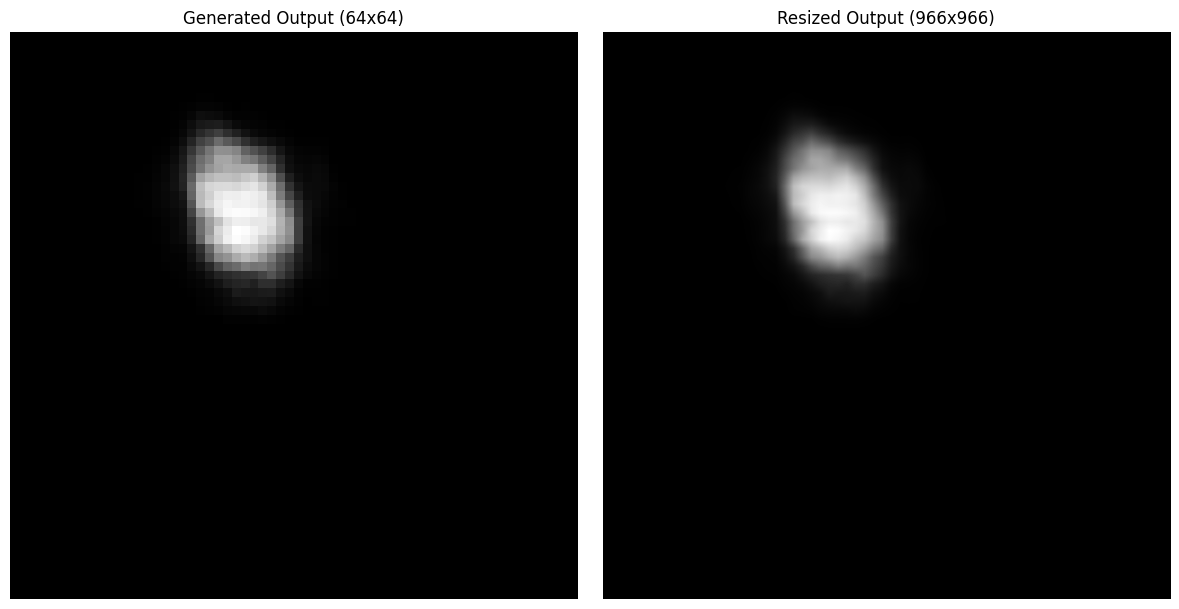

In [16]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load the best trained model
model.load_state_dict(torch.load('/home/tim/Documents/04_Projekt_ConSim/lens_contamination_simulation/train_model/models/best_model_droplet.pth'))
model.eval()  # Set to evaluation mode

# Input: x=0.3, y=0.3, size=0.3
input_data = torch.tensor([[0.4, 0.3, 0.1]], dtype=torch.float32).to(device)

# Generate output from the model
with torch.no_grad():  # Disable gradients for inference
    output = model(input_data)

# The output is a tensor of shape (1, 1, 64, 64) - grayscale mask
output = output.squeeze(0).squeeze(0).cpu().numpy()  # Convert to numpy array for plotting


# Resize the output to 966x966 using bilinear interpolation
resized_output = F.interpolate(torch.tensor(output).unsqueeze(0).unsqueeze(0), size=(966, 966), mode='bilinear', align_corners=False)
resized_output = resized_output.squeeze(0).squeeze(0).numpy()  # Convert back to numpy for plotting

# Plot the original and resized outputs side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original output (64x64)
axes[0].imshow(output, cmap='gray')
axes[0].set_title('Generated Output (64x64)')
axes[0].axis('off')
# Plot the resized output (966x966)
axes[1].imshow(resized_output, cmap='gray')
axes[1].set_title('Resized Output (966x966)')
axes[1].axis('off')

# Show both plots side by side
plt.tight_layout()
plt.show()


In [ ]:
"""
Ab 0.6 kommen zwei --> Daten Augementierung für groesssere Tropfen!


"""